# 加载和浏览数据集

In [2]:
quality = read.csv("../../datas/Diabetes.csv")
str(quality)

'data.frame':	131 obs. of  14 variables:
 $ MemberID            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ InpatientDays       : int  0 1 0 0 8 2 16 2 2 4 ...
 $ ERVisits            : int  0 1 0 1 2 0 1 0 1 2 ...
 $ OfficeVisits        : int  18 6 5 19 19 9 8 8 4 0 ...
 $ Narcotics           : int  1 1 3 0 3 2 1 0 3 2 ...
 $ DaysSinceLastERVisit: num  731 411 731 158 449 ...
 $ Pain                : int  10 0 10 34 10 6 4 5 5 2 ...
 $ TotalVisits         : int  18 8 5 20 29 11 25 10 7 6 ...
 $ ProviderCount       : int  21 27 16 14 24 40 19 11 28 21 ...
 $ MedicalClaims       : int  93 19 27 59 51 53 40 28 20 17 ...
 $ ClaimLines          : int  222 115 148 242 204 156 261 87 98 66 ...
 $ StartedOnCombination: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ AcuteDrugGapSmall   : int  0 1 5 0 0 4 0 0 0 0 ...
 $ PoorCare            : int  0 0 0 0 0 1 0 0 1 0 ...


MemberID是从1到131 对患者进行编号的唯一标识符。   
InpatientDays是住院次数或患者在医院度过的天数。   
ERVisits是患者访问急诊室的次数。   
OfficeVisits是患者拜访任何医生办公室的次数。   
Narcotics是患者对麻醉剂开出的处方数量。   
DaysSinceLastERVisit是患者上次急诊室（ER）到研究期结束之间的天数，如果患者从未去过ER，则将其设置为研究期的长度。   
Pain是患者抱怨疼痛的就诊次数。     
TotalVisits是患者拜访任何医疗保健提供者的总次数。      
ProviderCount是为患者提供服务的提供者的数量。    
MedicalClaims是患者提出医疗要求的天数。   
ClaimLines是医疗索赔的总数。   
StartedOnCombination是患者是否开始使用药物组合治疗糖尿病。   
AcuteDrugGapSmall是处方用完后迅速补充的急性药物的一部分。   
PoorCare是因变量，如果患者护理不佳，则等于1，如果患者护理得好，则等于0。   

通过使用`table()`，我们可以看到有多少患者接受了较差的护理，有多少患者获得了良好的护理。

In [3]:
table(quality$PoorCare)


 0  1 
98 33 

护理不佳的患者百分比可以如下计算。

In [4]:
percPC = sum(quality$PoorCare)/nrow(quality)
percPC

[1] 0.2519084

In [5]:
summary(quality$PoorCare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.2519  0.5000  1.0000 

数据中`PoorCare`是数值变量，但是从实际问题出发，我们应该将其转化为类别变量

In [6]:
quality$PoorCare = as.factor(quality$PoorCare)
str(quality)

'data.frame':	131 obs. of  14 variables:
 $ MemberID            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ InpatientDays       : int  0 1 0 0 8 2 16 2 2 4 ...
 $ ERVisits            : int  0 1 0 1 2 0 1 0 1 2 ...
 $ OfficeVisits        : int  18 6 5 19 19 9 8 8 4 0 ...
 $ Narcotics           : int  1 1 3 0 3 2 1 0 3 2 ...
 $ DaysSinceLastERVisit: num  731 411 731 158 449 ...
 $ Pain                : int  10 0 10 34 10 6 4 5 5 2 ...
 $ TotalVisits         : int  18 8 5 20 29 11 25 10 7 6 ...
 $ ProviderCount       : int  21 27 16 14 24 40 19 11 28 21 ...
 $ MedicalClaims       : int  93 19 27 59 51 53 40 28 20 17 ...
 $ ClaimLines          : int  222 115 148 242 204 156 261 87 98 66 ...
 $ StartedOnCombination: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ AcuteDrugGapSmall   : int  0 1 5 0 0 4 0 0 0 0 ...
 $ PoorCare            : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 2 1 ...


# 分割数据集以进行训练和测试
通常，我们有训练集和测试集，然而在现实情况下，我们只有一个数据集。因此我们将用到`caTools`这一库，以完成随机的训练集和测试集的分配

In [7]:
library(caTools)

设置`seed`以便于每次每次生成的是相同的随机数，这样有助于检验结果

In [8]:
set.seed(123)
split = sample.split(quality$PoorCare, SplitRatio = 0.70)
split

[1]  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
 [13] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
 [25] FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE
 [37]  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
 [49]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE
 [73]  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
 [85] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
[109]  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE
[121]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE

`sample.split()`函数中的第一个参数确保训练集和测试集合`PoorCare`的比例是相同的。

让我们使用`subset()`创建训练和测试集。`TRUE`表示我们应该将该观察结果放入训练集中，而`FALSE`意味着我们应该将该观察结果放入测试集中。

In [9]:
qualityTrain = subset(quality, split == TRUE)
qualityTest = subset(quality, split == FALSE)

我们可以检查训练集和测试集中的数据点数量，并确认接受不良护理的患者比例确实与整个数据集相似。

In [10]:
table(qualityTrain$PoorCare)


 0  1 
69 23 

In [11]:
table(qualityTest$PoorCare)


 0  1 
29 10 

# 建立Logistic回归模型
使用函数`glm()`表示广义线性模型，参数`family = binomial`表示我们正在尝试预测两种可能的结果，以便从广义线性模型的类别中调用逻辑回归模型。

In [12]:
QualityLog = glm(PoorCare ~ OfficeVisits + Narcotics, data = qualityTrain, family = binomial)
summary(QualityLog)


Call:
glm(formula = PoorCare ~ OfficeVisits + Narcotics, family = binomial, 
    data = qualityTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3483  -0.5824  -0.4584  -0.2302   2.1552  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.84649    0.60526  -4.703 2.56e-06 ***
OfficeVisits  0.07720    0.03283   2.352  0.01870 *  
Narcotics     0.10613    0.03699   2.869  0.00411 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 103.470  on 91  degrees of freedom
Residual deviance:  75.674  on 89  degrees of freedom
AIC: 81.674

Number of Fisher Scoring iterations: 5


`AIC`是模型质量的量度，类似于调整$R^2$。因为它说明了所使用的变量数与观测值数之比。它提供了一种模型选择的方法，但是只能使用它来比较基于相同数据集构建的模型。

首选模型是具有最小AIC的模型。最后一行与用于计算系数（通过解决优化问题）的算法（默认情况下为Newton-Raphson算法或Newton方法）有关。

# 样品中模型验证
## 敏感性和特异性（ReCall）
`type = "response"`确保算法使用逻辑响应函数来计算预测

In [13]:
predictTrain = predict(QualityLog, type = "response")
summary(predictTrain)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05486 0.09932 0.13446 0.25000 0.26498 0.99623 

让我们看一下训练集中前十名患者接受不良护理的预期概率，并将其与实际观察结果进行比较。

In [14]:
predictTrain[1:10]

1          3          6          7          8          9         11 
0.20574139 0.10506987 0.12570812 0.10690266 0.09718481 0.09802901 0.25156838 
        12         14         15 
0.13220566 0.27207140 0.46631314

In [15]:
qualityTrain$PoorCare[1:10]

[1] 0 0 1 0 0 1 0 0 0 0
Levels: 0 1

通过输出均值查看模型是否如我们预期的那样为实际的`PoorCare`案例预测了更高的概率。

In [16]:
tapply(predictTrain, qualityTrain$PoorCare, mean)

0         1 
0.1691589 0.4925233

如果使用0.5作为阈值，则会得到以下混淆矩阵。

In [17]:
conf05 = table(qualityTrain$PoorCare, predictTrain > 0.5)
conf05

   
    FALSE TRUE
  0    66    3
  1    13   10

我们在预测`PoorCare`的情况下犯了3个错误，但`Caregood`；在预测`Caregood`的好的情况下犯了13个错误，但是`PoorCare`。     

预测准确性为$76/92 = 82.61\%$

灵敏度或真实阳性率（$=10/23 = 0.43$）

特异性或真实阴性率（$=66/69 = 0.96$）。

尝试提高阈值或者降低阈值

In [18]:
conf07 = table(qualityTrain$PoorCare, predictTrain > 0.7)
conf07

   
    FALSE TRUE
  0    68    1
  1    14    9

In [19]:
conf02 = table(qualityTrain$PoorCare, predictTrain > 0.2)
conf02

   
    FALSE TRUE
  0    51   18
  1     7   16

通过增加阈值，敏感性下降，特异性上升；通过降低阈值，敏感性提高，特异性降低

# ROC曲线
又叫接收者操作特征曲线

package `ROCR`负责画出ROC曲线

In [28]:
library(ROCR)

用训练集的预测创建ROC曲线

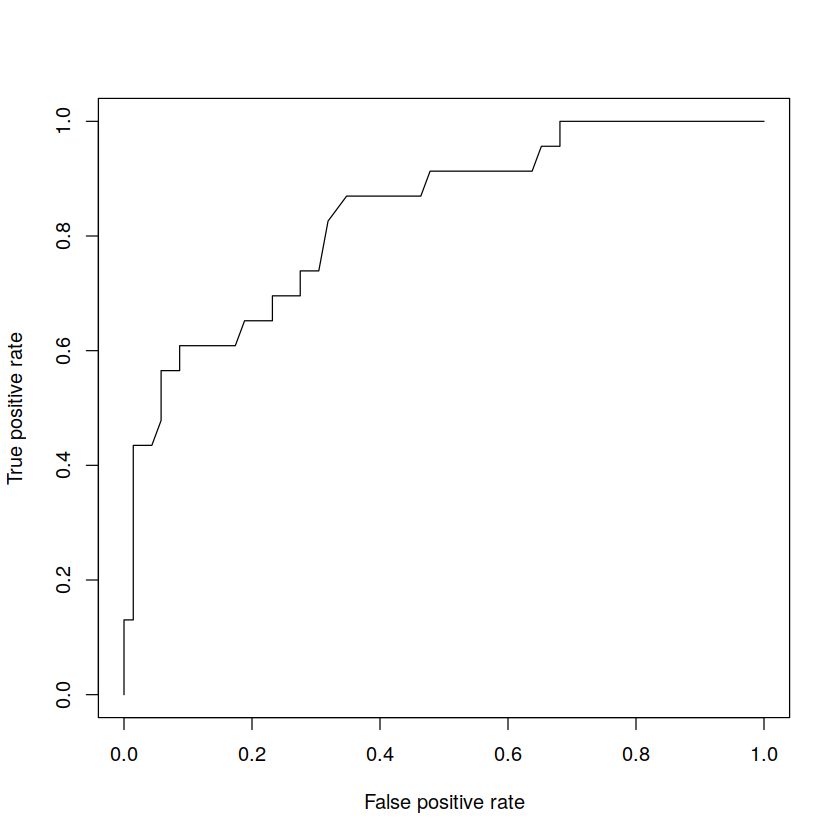

In [29]:
ROCRpred = prediction(predictTrain, qualityTrain$PoorCare)
ROCRperf = performance(ROCRpred, "tpr", "fpr")
plot(ROCRperf)

为ROC图添加更多视觉效果。

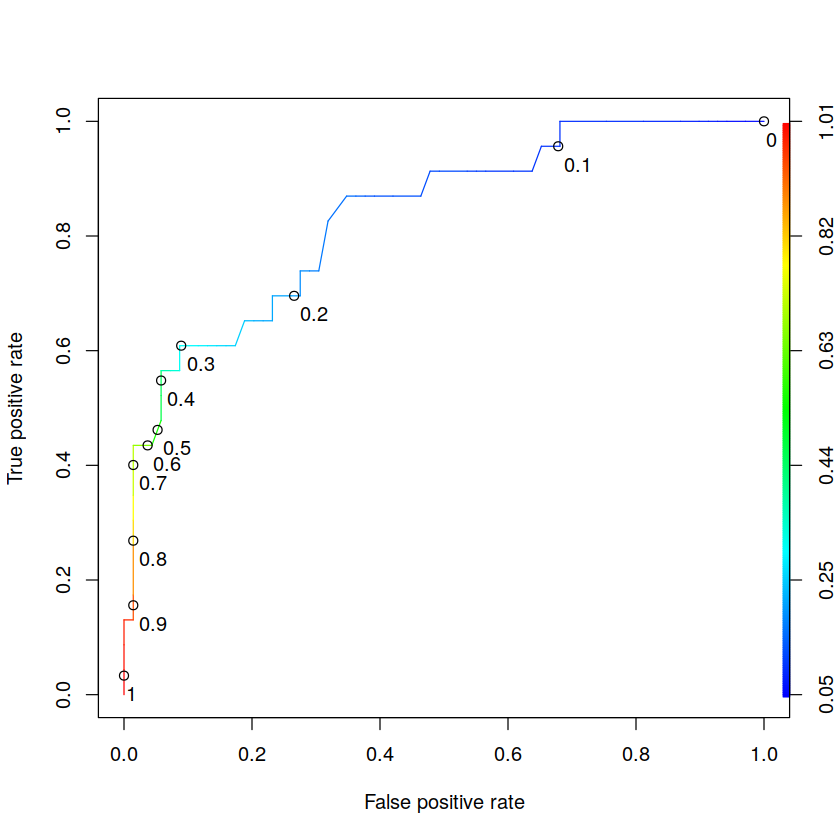

In [30]:
plot(ROCRperf, colorize = TRUE, print.cutoffs.at = seq(0,1,0.1), text.adj = c(-0.2,1.7))

现在我们计算ROC曲线下面的面积，即AUC

In [31]:
ROCRauc = performance(ROCRpred, "auc")
ROCRauc@y.values

[[1]]
[1] 0.8349086

为ROC曲线下的区域着色，使用`pROC`包中的`plot.roc`功能

In [32]:
library(pROC)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



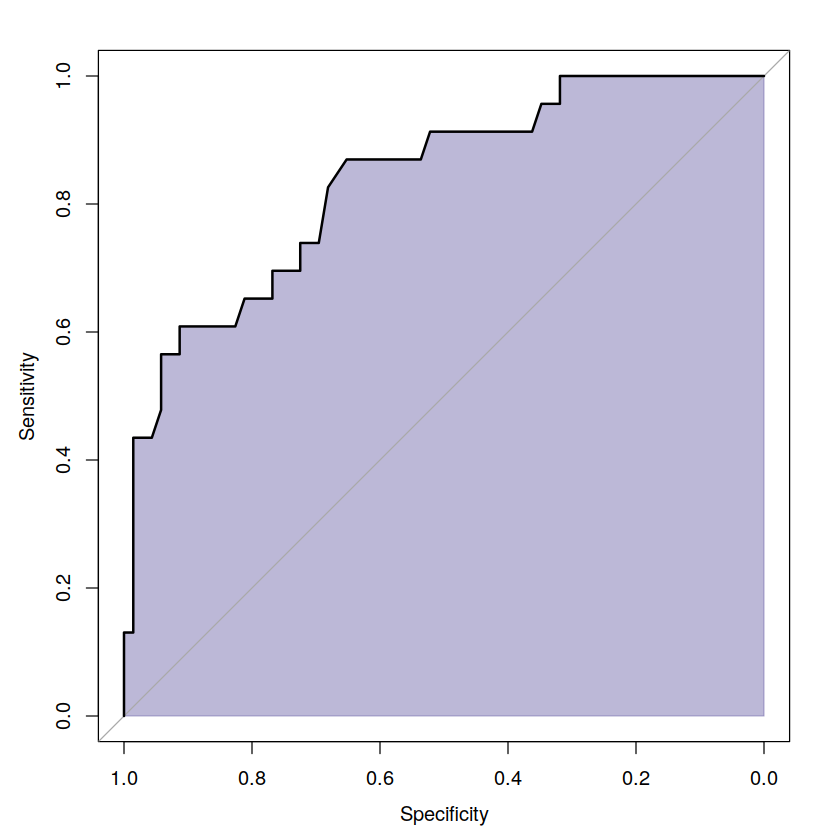

In [33]:
plot.roc(qualityTrain$PoorCare, predictTrain, 
    auc.polygon = TRUE, 
    auc.polygon.col=rgb(.35,0.31,0.61, alpha = 0.4), 
    auc.polygon.border=rgb(.35,0.31,0.61, 0.4))

默认情况下,`plot.roc`,x轴是特异性，等于（1-假阳性率），数字从1到0从左到右

# 样本外模型验证

In [34]:
predictTest = predict(QualityLog, type = "response", newdata = qualityTest)
conf03out = table(qualityTest$PoorCare, predictTest > 0.3)
conf03out

   
    FALSE TRUE
  0    27    2
  1     6    4

阈值为0.3的模型的样本外准确性$为31/39 = 79.49\%$。我们还可以绘制模型的样本外ROC并计算其样本外AUC。

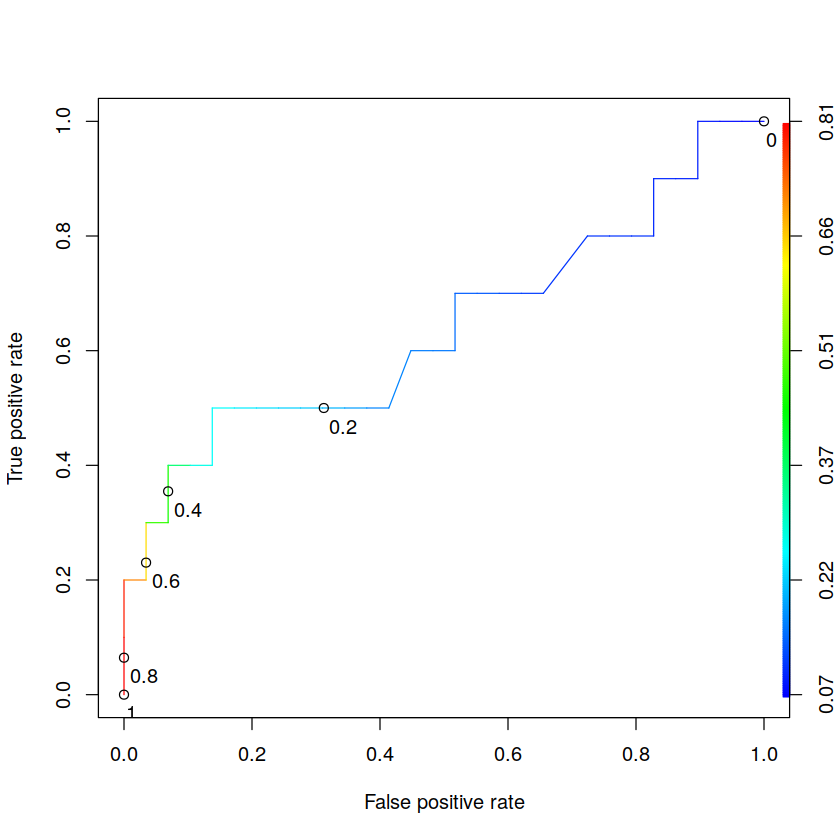

In [35]:
ROCRpredTest = prediction(predictTest, qualityTest$PoorCare)
ROCRperfTest = performance(ROCRpredTest, "tpr", "fpr")
plot(ROCRperfTest, colorize = TRUE, print.cutoffs.at = seq(0,1,0.2), text.adj = c(-0.2,1.7))